## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 0.95~\varepsilon / k_B$;
   - Скорости охлаждения: 
       - $v_0 = 0.1~\varepsilon / k_B\tau;$
       - $v_1 = 0.02~\varepsilon / k_B\tau;$
       - $v_2 = 0.004~\varepsilon / k_B\tau;$
       - $v_3 = 0.0008~\varepsilon / k_B\tau;$
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $N_{ne} = 2000, 10000, 10000, 20000$;
       - $M_0 = 2000;$
       - $M_1 = 10000;$
       - $M_2 = 10000;$
       - $M_3 = 20000;$
   - Равновесные характеристики системы рассчитывалась через каждые $M_i$ шагов;
   - Число ансамблей $N=1000$;
   - Подсчёт состоял из $2N+499$ шагов: $500$ на уравновешивание системы при фиксированной температуре и $2N-1$ на усреднение по ансамблям (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.postprocessing import PostProcessor, RegressionRDF

#### Настройки рисунков

In [2]:
FIGSIZE = (7, 7)
FONTSIZE = 14

plt.style.use('seaborn')
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize'] = FONTSIZE
plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['font.size'] = FONTSIZE

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)


#### Путь к файлам с данными

In [3]:
CURRENT_DATA_LIST = [
    '2021-05-20_cooling_T_1.0_HV_1e-1',
    '2021-05-27_cooling_T_1.0_HV_9e-2',
    '2021-05-27_cooling_T_1.0_HV_8e-2',
    '2021-05-27_cooling_T_1.0_HV_7e-2',
    '2021-05-27_cooling_T_1.0_HV_6e-2',
    '2021-05-27_cooling_T_1.0_HV_5e-2',
    '2021-05-27_cooling_T_1.0_HV_4e-2',
    '2021-05-27_cooling_T_1.0_HV_3e-2',
    '2021-05-20_cooling_T_1.0_HV_2e-2',
    '2021-05-27_cooling_T_1.0_HV_1e-2',
    '2021-05-20_cooling_T_1.0_HV_4e-3',
    '2021-05-20_cooling_T_1.0_HV_8e-4',
]
PLOT_FILENAME_POSTFIX = 'slow_cooling_1.0'

In [4]:
PATHS_TO_CURRENT_DATA = [
    os.path.join(con.PATH_TO_DATA, path)
    for path in CURRENT_DATA_LIST
]
PATHS_TO_CURRENT_DATA

['C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-20_cooling_T_1.0_HV_1e-1',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_9e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_8e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_7e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_6e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_5e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_4e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-27_cooling_T_1.0_HV_3e-2',
 'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\

In [5]:
PATH_TO_CURRENT_PLOTS = os.path.join(os.path.dirname(con.PATH_TO_DATA), 'plots', CURRENT_DATA_LIST[0][:-8])
PATH_TO_CURRENT_PLOTS

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\plots\\2021-05-20_cooling_T_1.0'

#### Пользовательские функции

In [6]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры системы, при которых были подчитаны функции радиального распределения, среднеквадратичные смещения и т.д.

In [8]:
setups_list = []
for path in PATHS_TO_CURRENT_DATA:
    setups = []
    for filename in os.listdir(path)[::-1]:
        if filename.startswith('rdf'):
            parts = filename[:-4].split('_')
            setup = {
                'temperature': float(parts[2]), 
                'pressure': float(parts[4]) if 'P' in parts else None,
                'heating_velocity': float(parts[6]) if 'HV' in parts else None,

            }
            setups.append(setup)
    
    setups_list.append(setups)
    
setups_list

[[{'temperature': 0.99912, 'pressure': -2.19015, 'heating_velocity': 0.1},
  {'temperature': 0.94739, 'pressure': 0.67678, 'heating_velocity': 0.1}],
 [{'temperature': 0.99917, 'pressure': -2.19011, 'heating_velocity': 0.09},
  {'temperature': 0.94892, 'pressure': 0.7463, 'heating_velocity': 0.09}],
 [{'temperature': 0.99922, 'pressure': -2.19007, 'heating_velocity': 0.08},
  {'temperature': 0.95243, 'pressure': 0.73234, 'heating_velocity': 0.08}],
 [{'temperature': 0.99927, 'pressure': -2.19003, 'heating_velocity': 0.07},
  {'temperature': 0.94881, 'pressure': 0.73919, 'heating_velocity': 0.07}],
 [{'temperature': 0.99932, 'pressure': -2.19, 'heating_velocity': 0.06},
  {'temperature': 0.95003, 'pressure': 0.76931, 'heating_velocity': 0.06}],
 [{'temperature': 0.99937, 'pressure': -2.18996, 'heating_velocity': 0.05},
  {'temperature': 0.94561, 'pressure': 0.74089, 'heating_velocity': 0.05}],
 [{'temperature': 0.99942, 'pressure': -2.18992, 'heating_velocity': 0.04},
  {'temperature': 

#### Температуры, для которых функция радиального распределения предсказывается

In [9]:
test_heating_velocities = [setup[0]['heating_velocity'] for setup in setups_list]
test_heating_velocities

[0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.004, 0.0008]

#### Инициализация объекта для обработки данных и вывод таблицы значений функции радиального распределения

In [10]:
postprocessors = [
    PostProcessor(
        path_to_data=path, 
        path_to_plots=PATH_TO_CURRENT_PLOTS, 
        plot_filename_postfix=PLOT_FILENAME_POSTFIX, 
        setups=setups_list[i],
    )
    for i, path in enumerate(PATHS_TO_CURRENT_DATA)
]
postprocessors[0].rdf.data

,radius,setup_0,setup_1
0,0.01,0.000000,0.000000
1,0.02,0.000000,0.000000
2,0.03,0.000000,0.000000
3,0.04,0.000000,0.000000
4,0.05,0.000000,0.000000
...,...,...,...
607,6.08,1.004241,1.003539
608,6.09,1.003577,1.003673
609,6.10,1.002819,1.004379
610,6.11,1.002681,1.004026


#### Графики функций радиального распределения $g(\textbf{r})$ при различных скоростях охлаждения

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

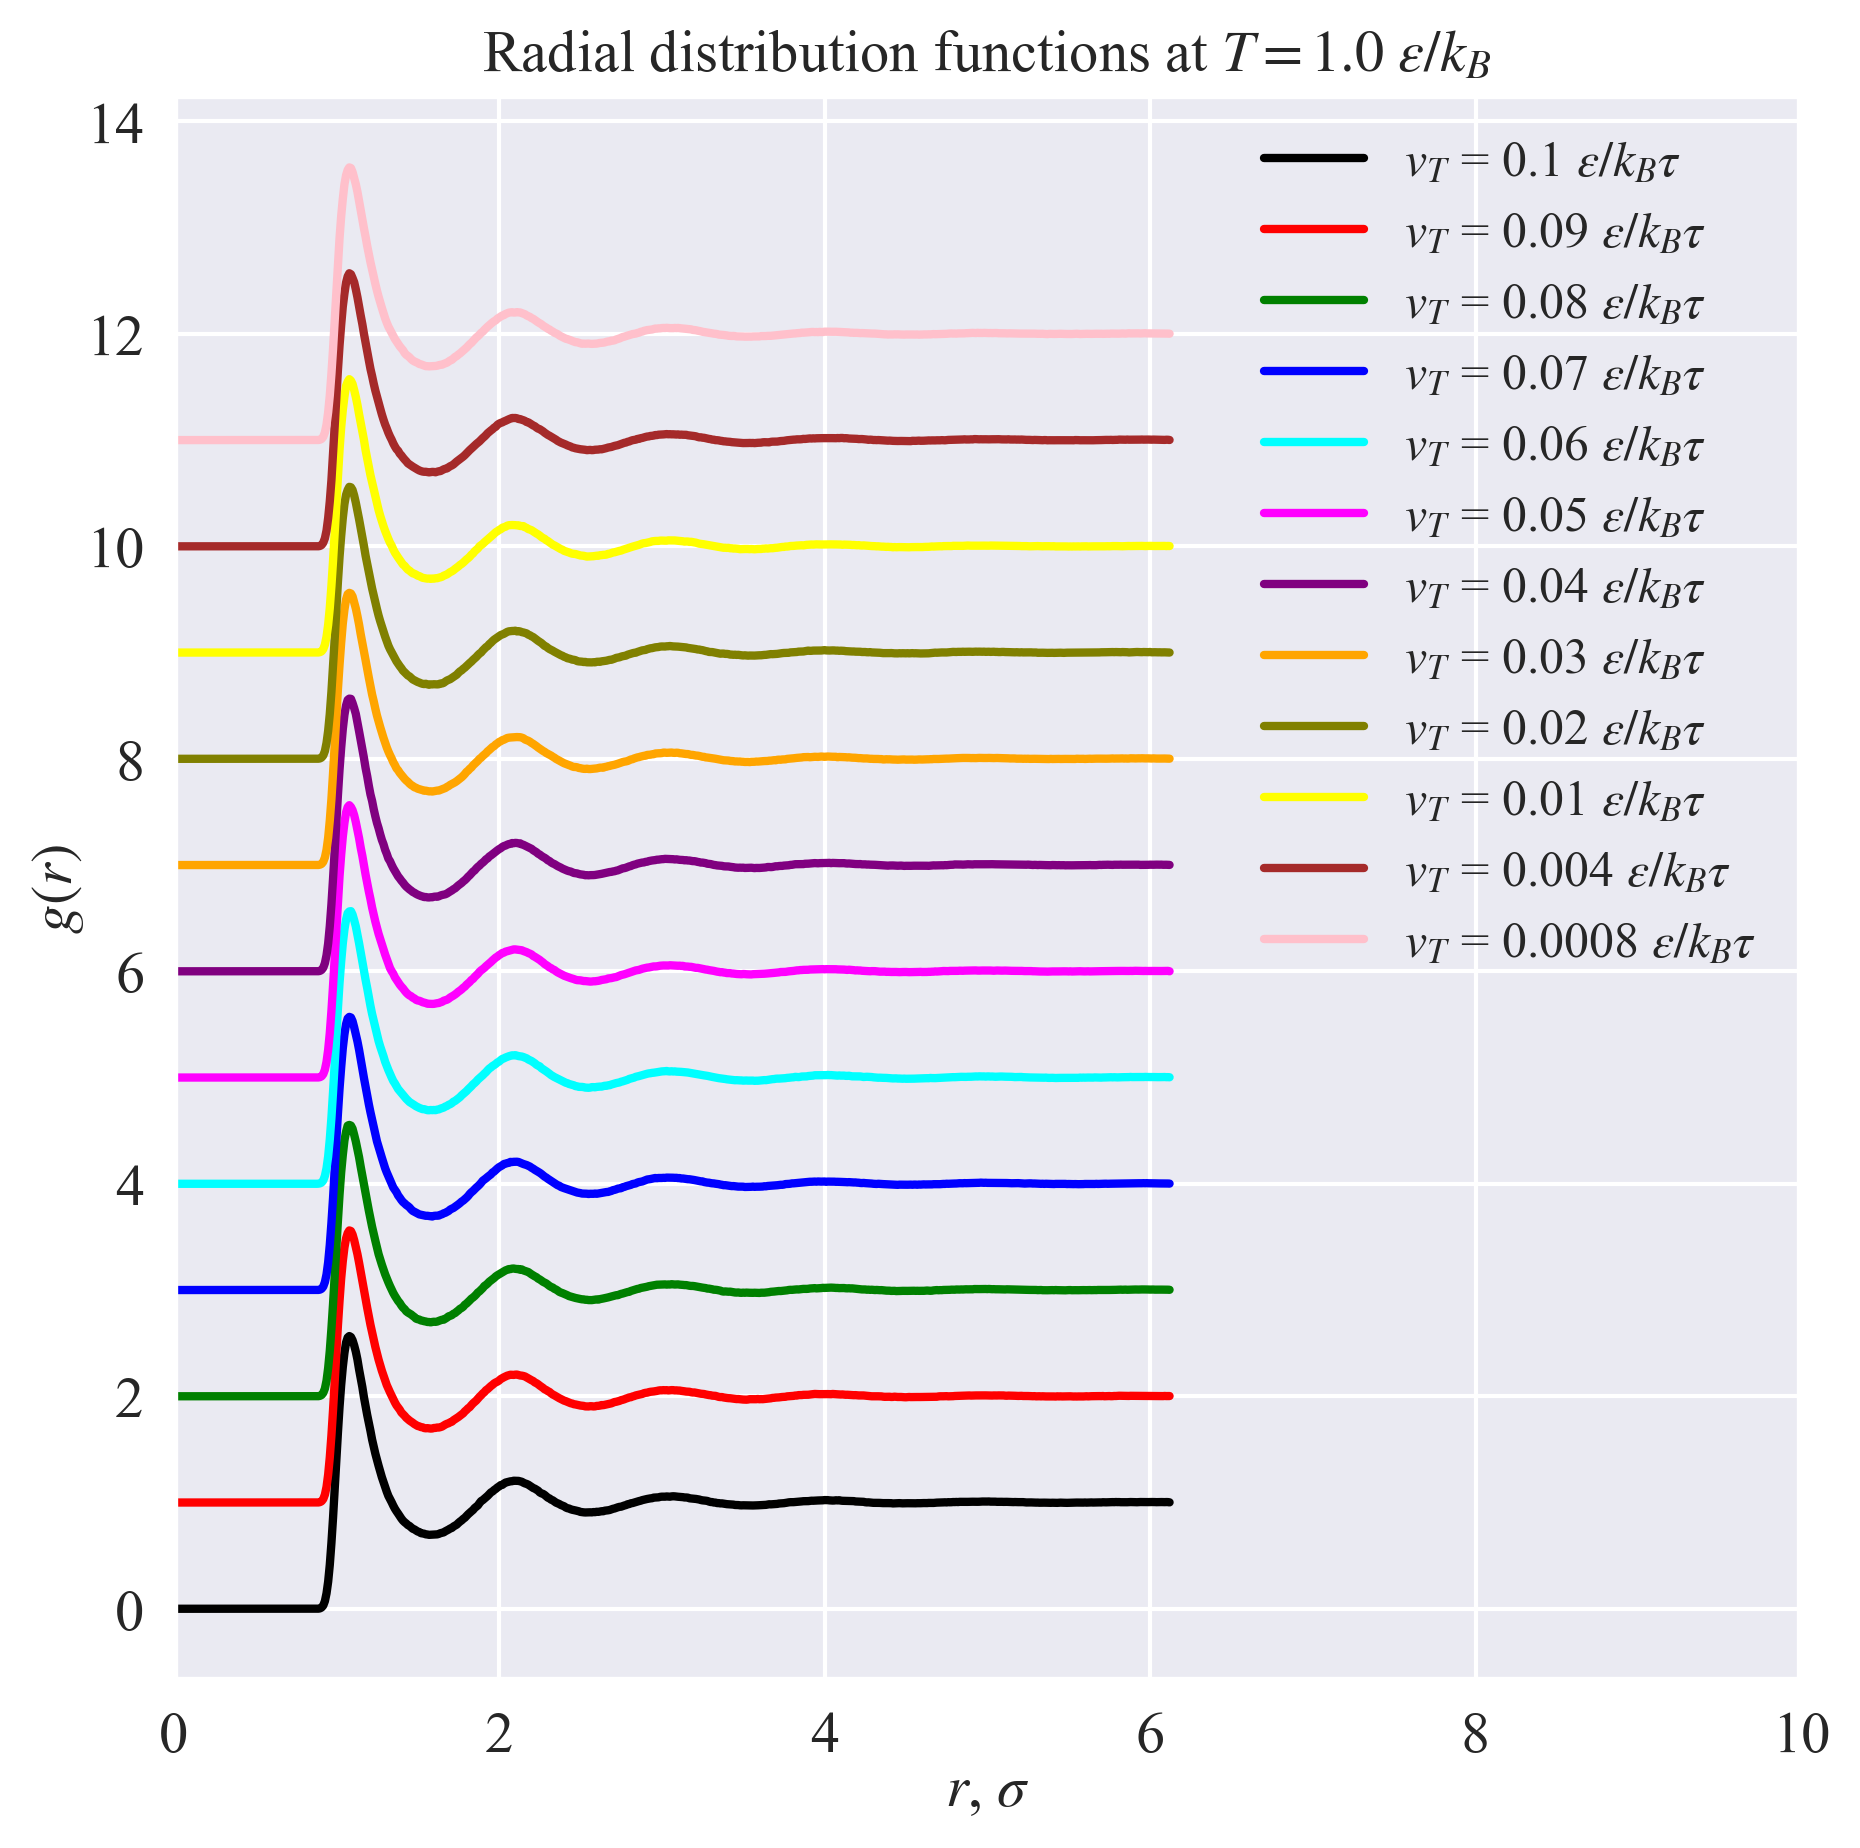

In [11]:
fig, ax = plt.subplots(figsize=FIGSIZE)
for i, pp in enumerate(postprocessors):
    ax.plot(
        pp.rdf.data['radius'],
        pp.rdf.data[f'setup_1'] + i,
        label=fr'$v_T$ = {setups_list[i][0]["heating_velocity"]} $\epsilon / k_B\tau$',
        color=COLORS[i],
    )
ax.set_xlabel(r'$r$, $\sigma $')
ax.set_ylabel('$g(r)$')
ax.set_xlim(
    left=0,
    right=10,
)
ax.set_ylim(
#     bottom=-0.1,
#     top=3,
)
ax.legend()
ax.set_title(fr'Radial distribution functions at $T = 1.0~\varepsilon / k_B$')
pp.save_plot(
    filename=(
        f'rdf'
        f'_{pp.plot_filename_postfix}'
        f'_full_size.png'
    )
)

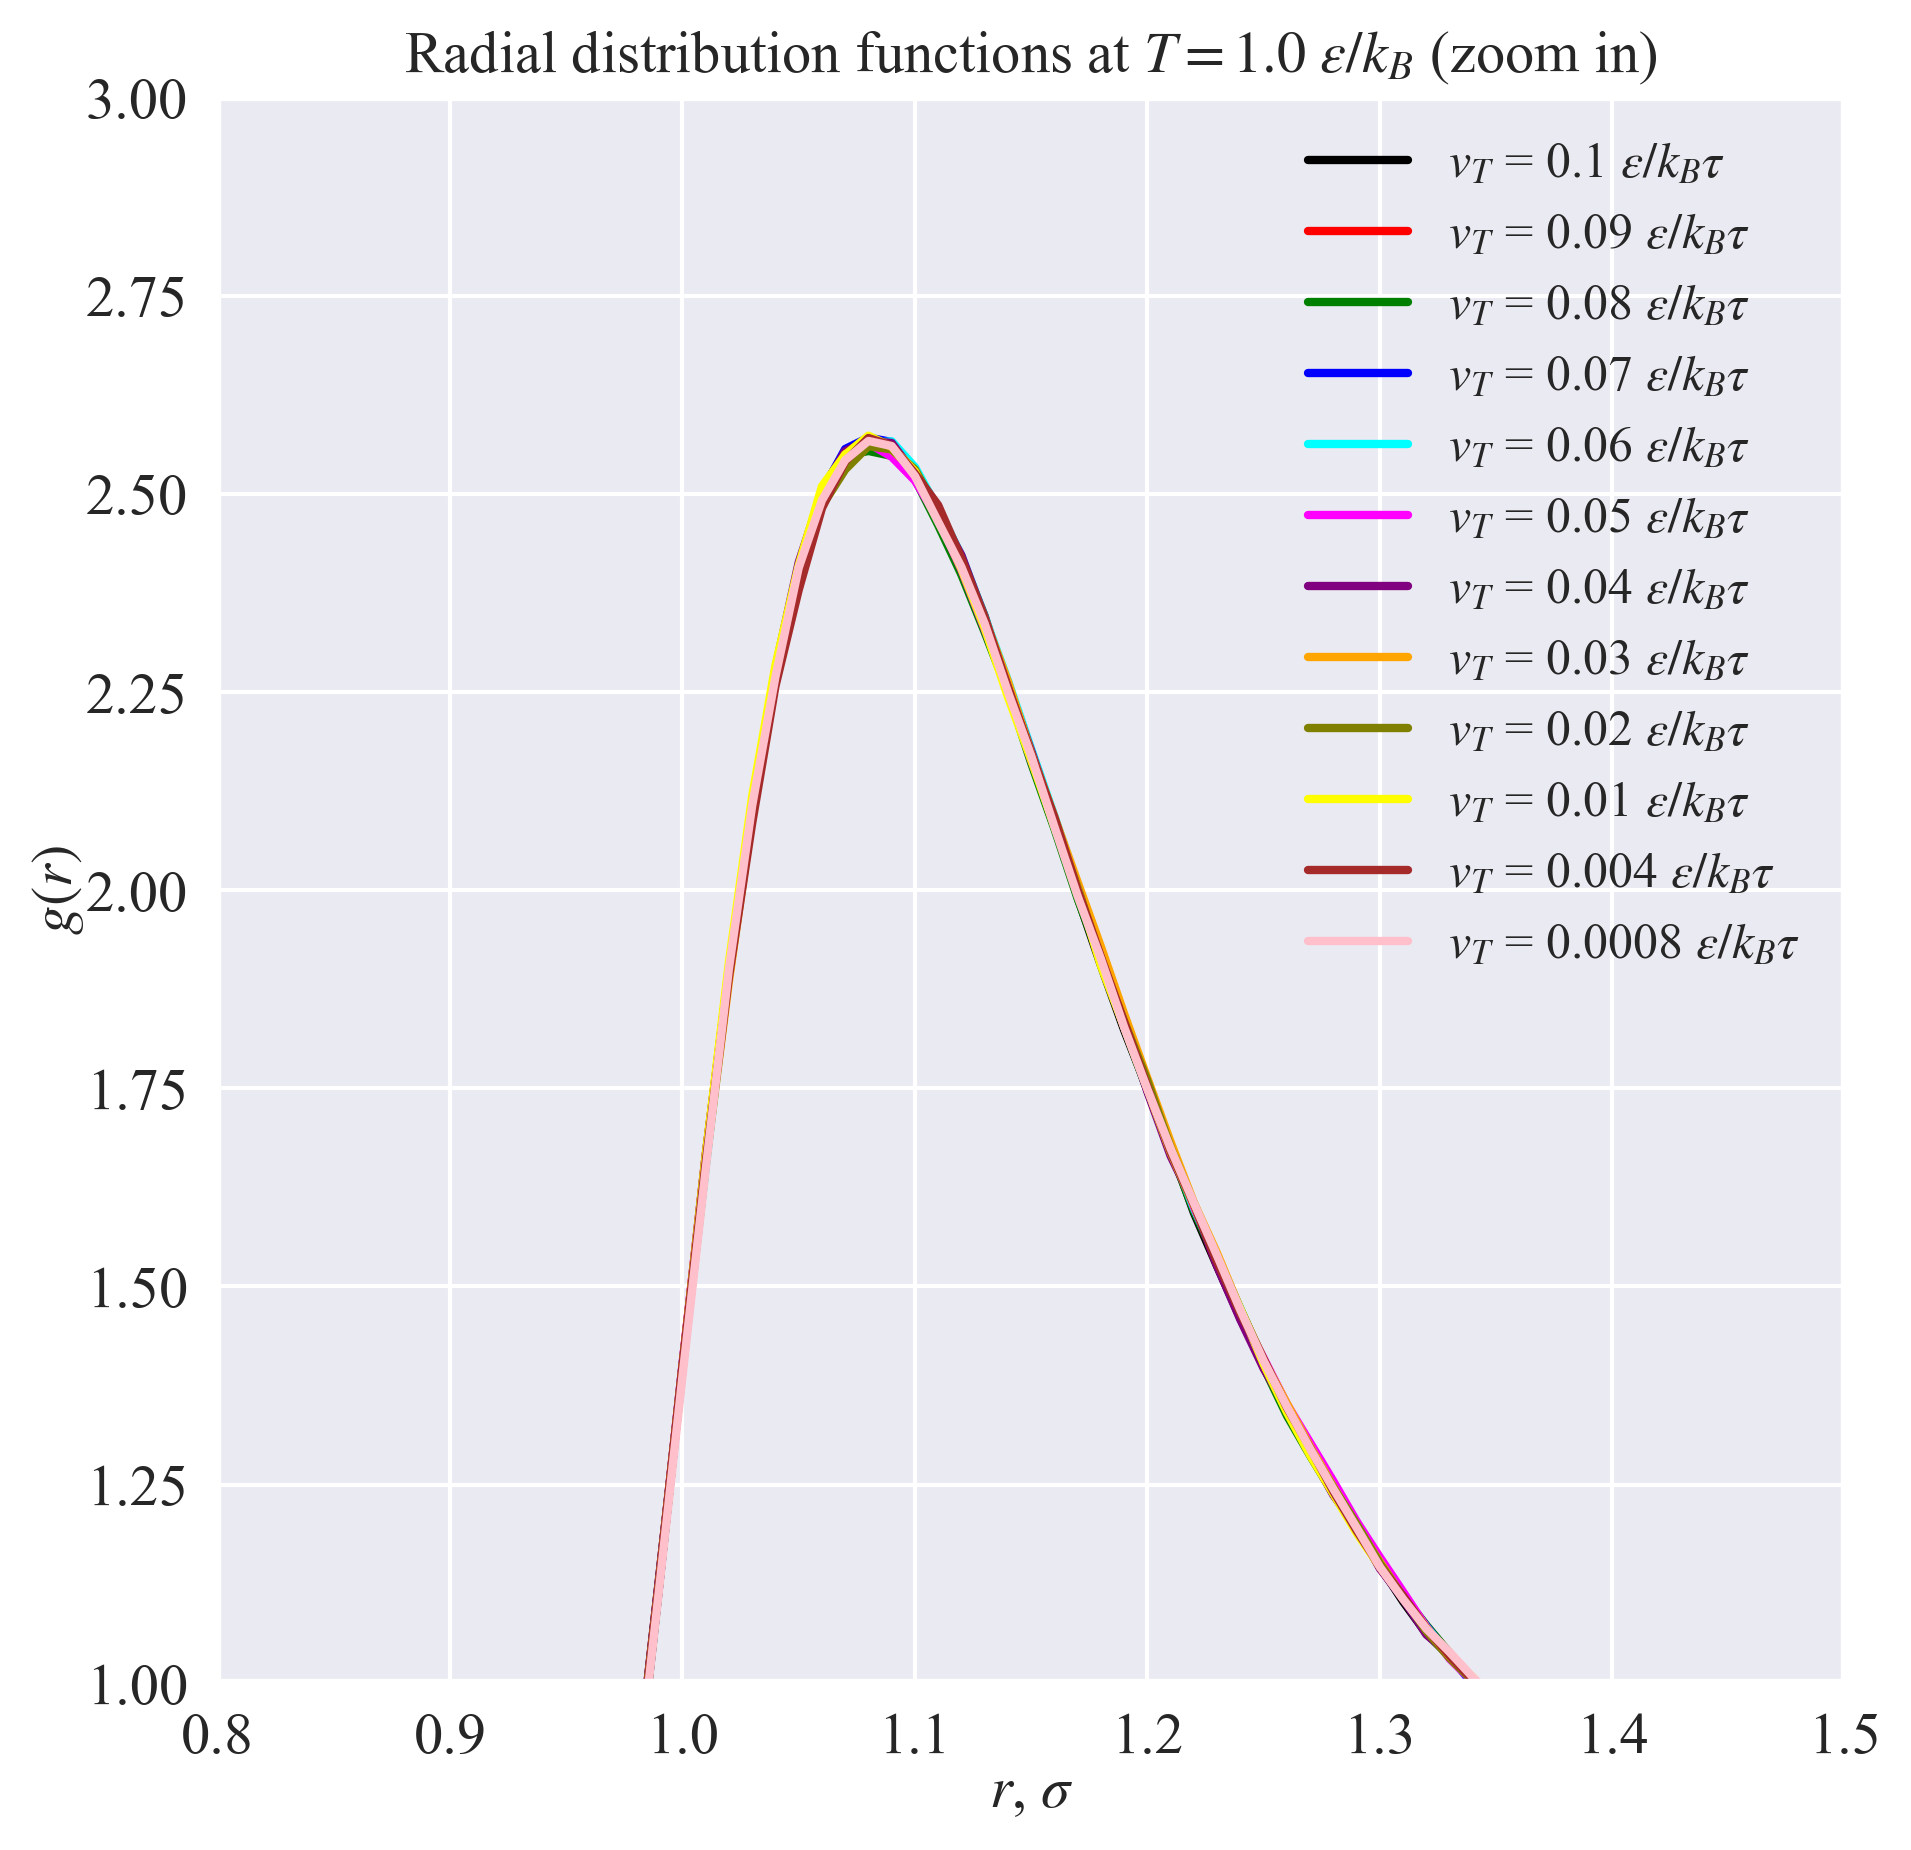

In [12]:
fig, ax = plt.subplots(figsize=FIGSIZE)
for i, pp in enumerate(postprocessors):
    ax.plot(
        pp.rdf.data['radius'],
        pp.rdf.data[f'setup_1'],
        label=fr'$v_T$ = {setups_list[i][0]["heating_velocity"]} $\epsilon / k_B\tau$',
        color=COLORS[i],
    )
ax.set_xlabel(r'$r$, $\sigma $')
ax.set_ylabel('$g(r)$')
ax.set_xlim(
    left=0.8,
    right=1.5,
)
ax.set_ylim(
    bottom=1,
    top=3,
)
ax.legend()
ax.set_title(fr'Radial distribution functions at $T = 1.0~\varepsilon / k_B$ (zoom in)')
pp.save_plot(
    filename=(
        f'rdf'
        f'_{pp.plot_filename_postfix}'
        f'_zoom_in.png'
    )
)

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [13]:
rdf_table = deepcopy(postprocessors[0].rdf.data)
rdf_table = rdf_table.drop(columns=['setup_0'])
rdf_table = rdf_table.rename(columns={'setup_1': f'{test_heating_velocities[0]}'})
for i, pp in enumerate(postprocessors[1:]):
    rdf_table = rdf_table.merge(
        right=pp.rdf.data,
        how='outer',
        on='radius',
    )
    rdf_table = rdf_table.drop(columns=['setup_0'])
    rdf_table = rdf_table.rename(columns={'setup_1': f'{test_heating_velocities[i + 1]}'})
rdf_table.index = rdf_table['radius']
rdf_table = rdf_table.drop(columns=['radius'])
rdf_table = rdf_table.T[::-1]
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004422,1.004192,1.003542,1.003237,1.002867,1.002720,1.002912,1.002595,1.002177,1.001302
0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004101,1.003045,1.002903,1.003549,1.002401,1.002412,1.001799,1.003220,1.002919,1.000926
0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002962,1.002885,1.002819,1.003689,1.003669,1.003598,1.003878,1.002445,1.003447,1.002743
0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003291,1.002385,1.002284,1.002629,1.001833,1.002158,1.002299,1.001281,1.001065,1.000232
0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003065,1.002343,1.002744,1.002266,1.002459,1.002302,1.002698,1.001980,1.000901,1.001177
0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003807,1.003868,1.003346,1.003419,1.003886,1.002553,1.003065,1.002807,1.002284,1.001315
0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002834,1.003618,1.003154,1.002906,1.002709,1.002827,1.003205,1.003547,1.003809,1.000374
0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004335,1.004660,1.003970,1.003869,1.004271,1.004717,1.004930,1.003710,1.003918,1.002717
0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004070,1.003432,1.003313,1.003116,1.002757,1.002586,1.002736,1.002944,1.002476,1.001608
0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003617,1.003913,1.004146,1.004150,1.003814,1.003806,1.003199,1.003632,1.003146,1.002119


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм линейной регрессии. То есть будем искать функции вида $g_i = k_iT + b_i$ Ниже показаны значения расстояния между частицами $r_i$, соответствующие значения коэффициентов $k_i, b_i$ и значения среднеквадратичной ошибки RMSE

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm

predicted_rdf_points = {key: [] for key in test_heating_velocities}
heating_velocities = rdf_table.index.values.astype(np.float64)
x_train = heating_velocities.reshape((heating_velocities.size, 1))
test_heating_velocities = np.array(heating_velocities)
x_test = test_heating_velocities.reshape((test_heating_velocities.size, 1))

regressors = {column: [] for column in rdf_table.columns}
for column in rdf_table.columns:
    y_train = rdf_table[column].values
#     regressor = KNeighborsRegressor(n_neighbors=4, weights='distance')
#     regressor = svm.SVR()
#     regressor = DecisionTreeRegressor()
    regressor = LinearRegression()
    regressor.fit(x_train, y_train)
    regressors[column] = regressor
    fitted_data = regressor.predict(x_test)
    
    for key, _ in predicted_rdf_points.items():
        predicted_rdf_points[key].append(fitted_data[np.where(test_heating_velocities == key)][0])

for key, value in predicted_rdf_points.items():
    predicted_rdf_points[key] = np.array(value)

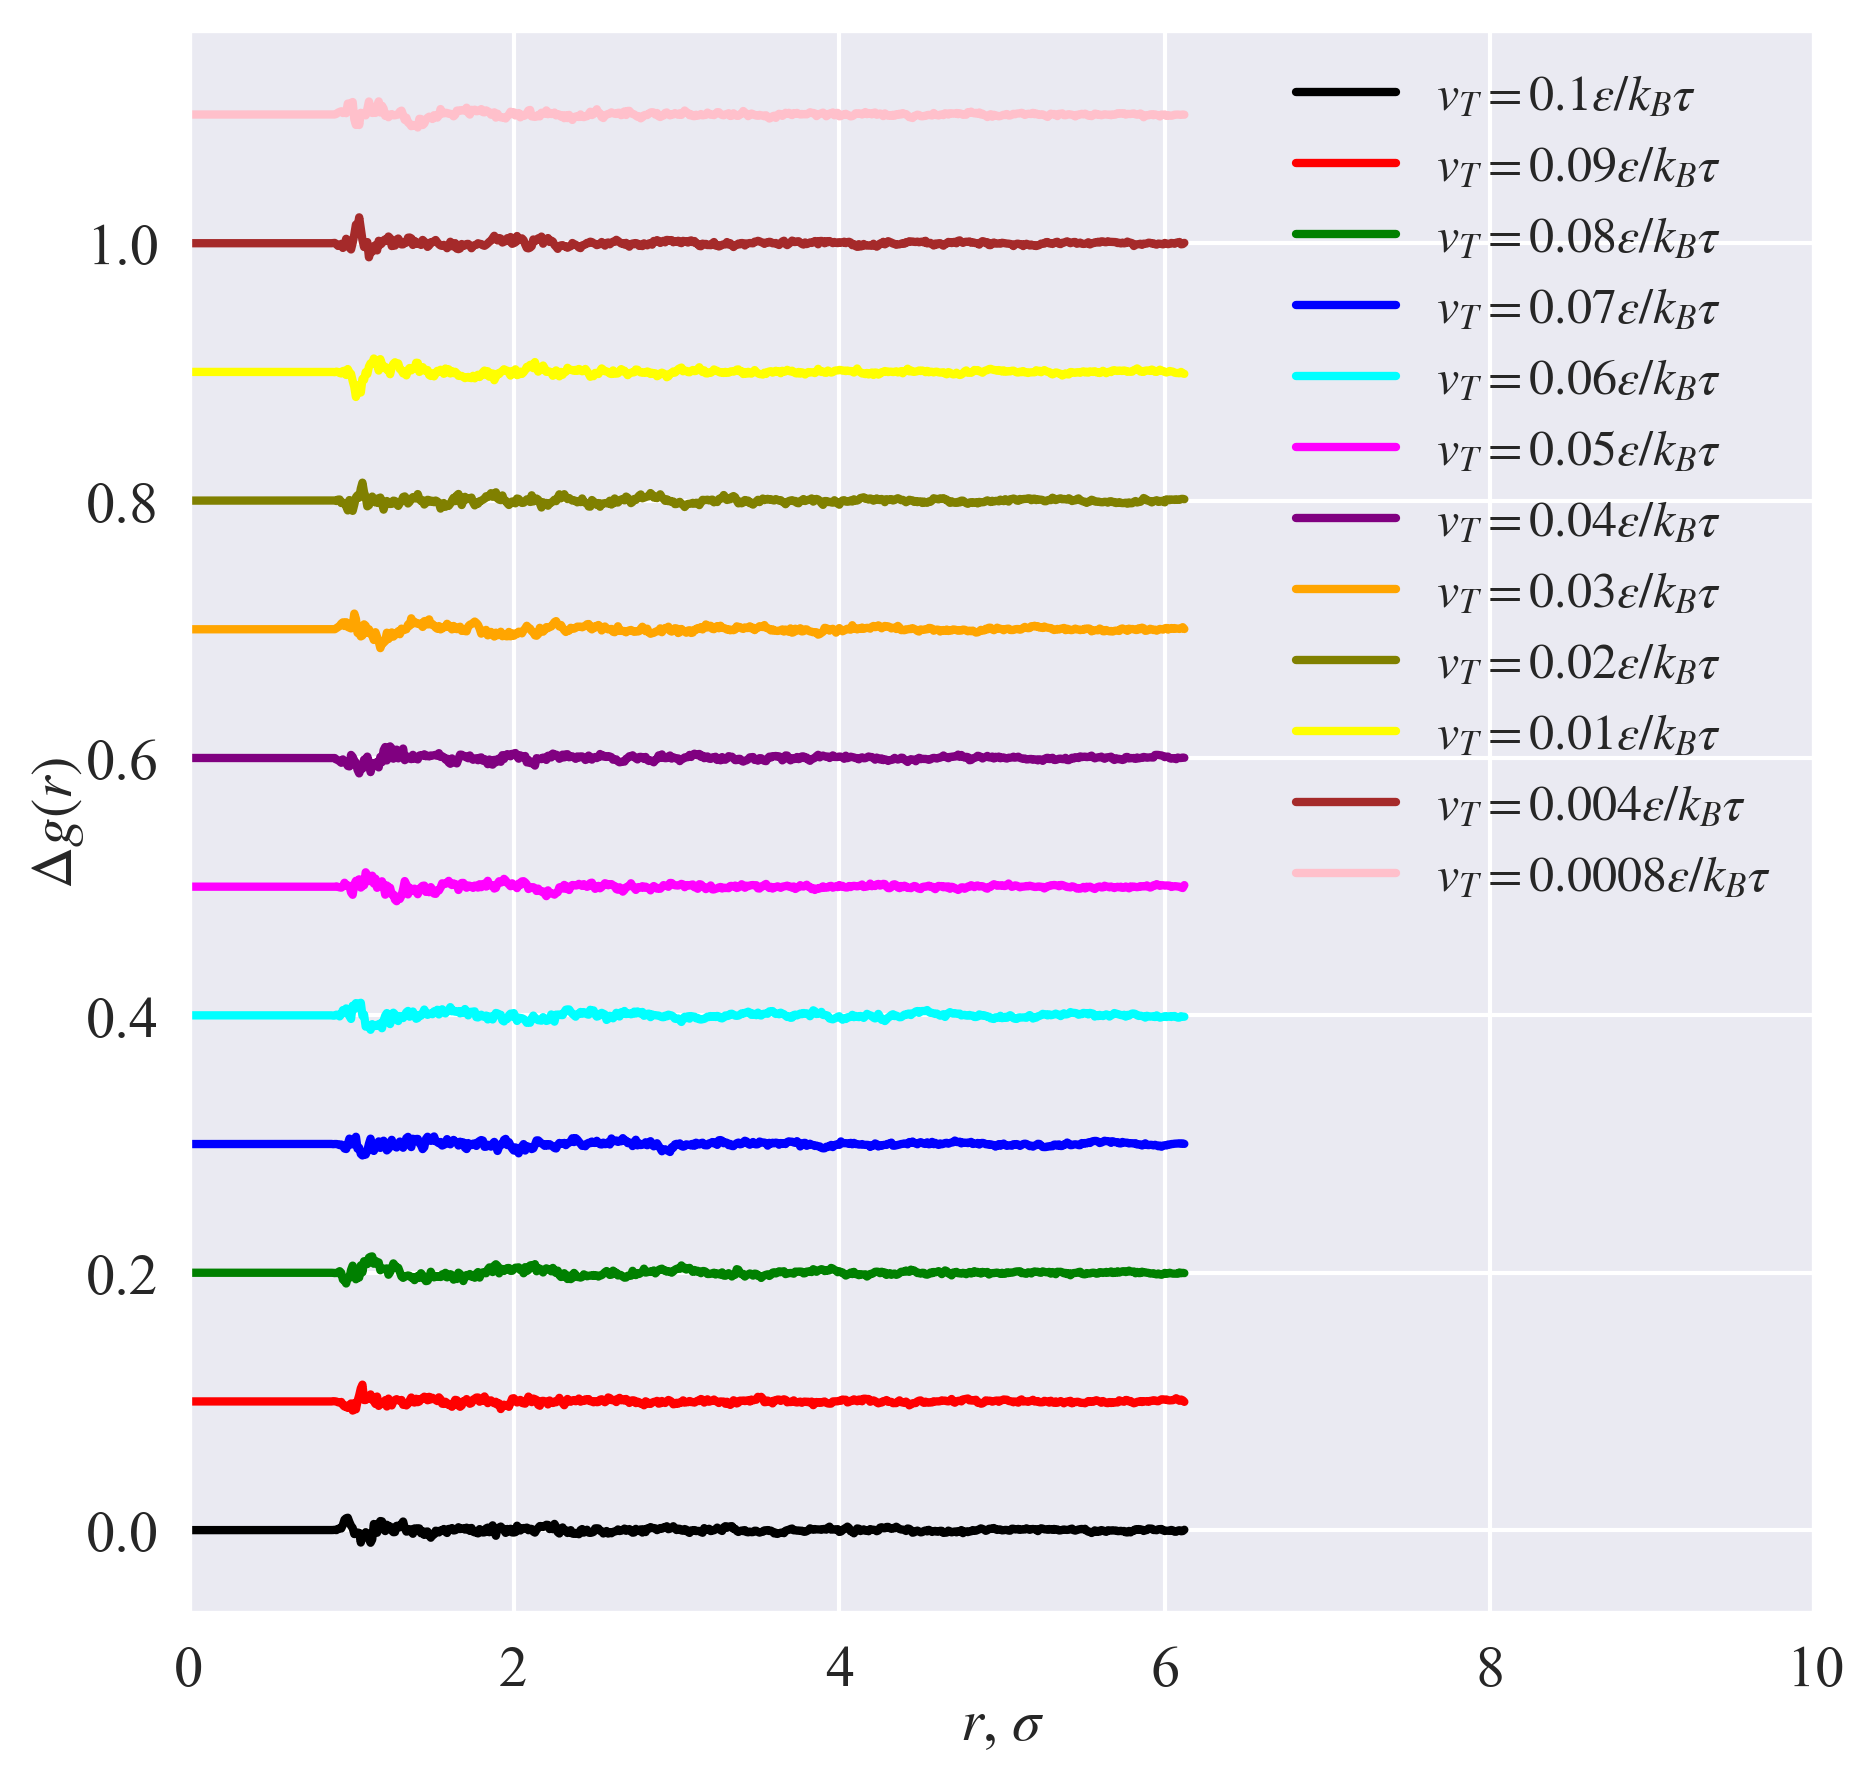

In [18]:
fig, ax = plt.subplots(figsize=FIGSIZE,)


for i, pp in enumerate(postprocessors):
    
    heating_velocity = setups_list[i][0]["heating_velocity"]
#     ax.plot(
#         pp.rdf.data['radius'],
#         pp.rdf.data[f'setup_1'] + i,
#         label=fr'$v_T = {heating_velocity} \epsilon / k_B\tau$',
#         color=COLORS[-i-1],
#     )
    ax.plot(
        rdf_table.columns.values, 
        predicted_rdf_points[heating_velocity] - pp.rdf.data[f'setup_1'] + i * 0.1,
        label=fr'$v_T = {heating_velocity} \epsilon / k_B\tau$',
        color=COLORS[i],
    );

ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$\Delta g(r)$');
ax.set_xlim(
    left=0, 
    right=10,
);
ax.set_ylim(
#     bottom=-1, 
#     top=16,
);
# ax.set_title('Radial distribution function')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_{PLOT_FILENAME_POSTFIX}.png')

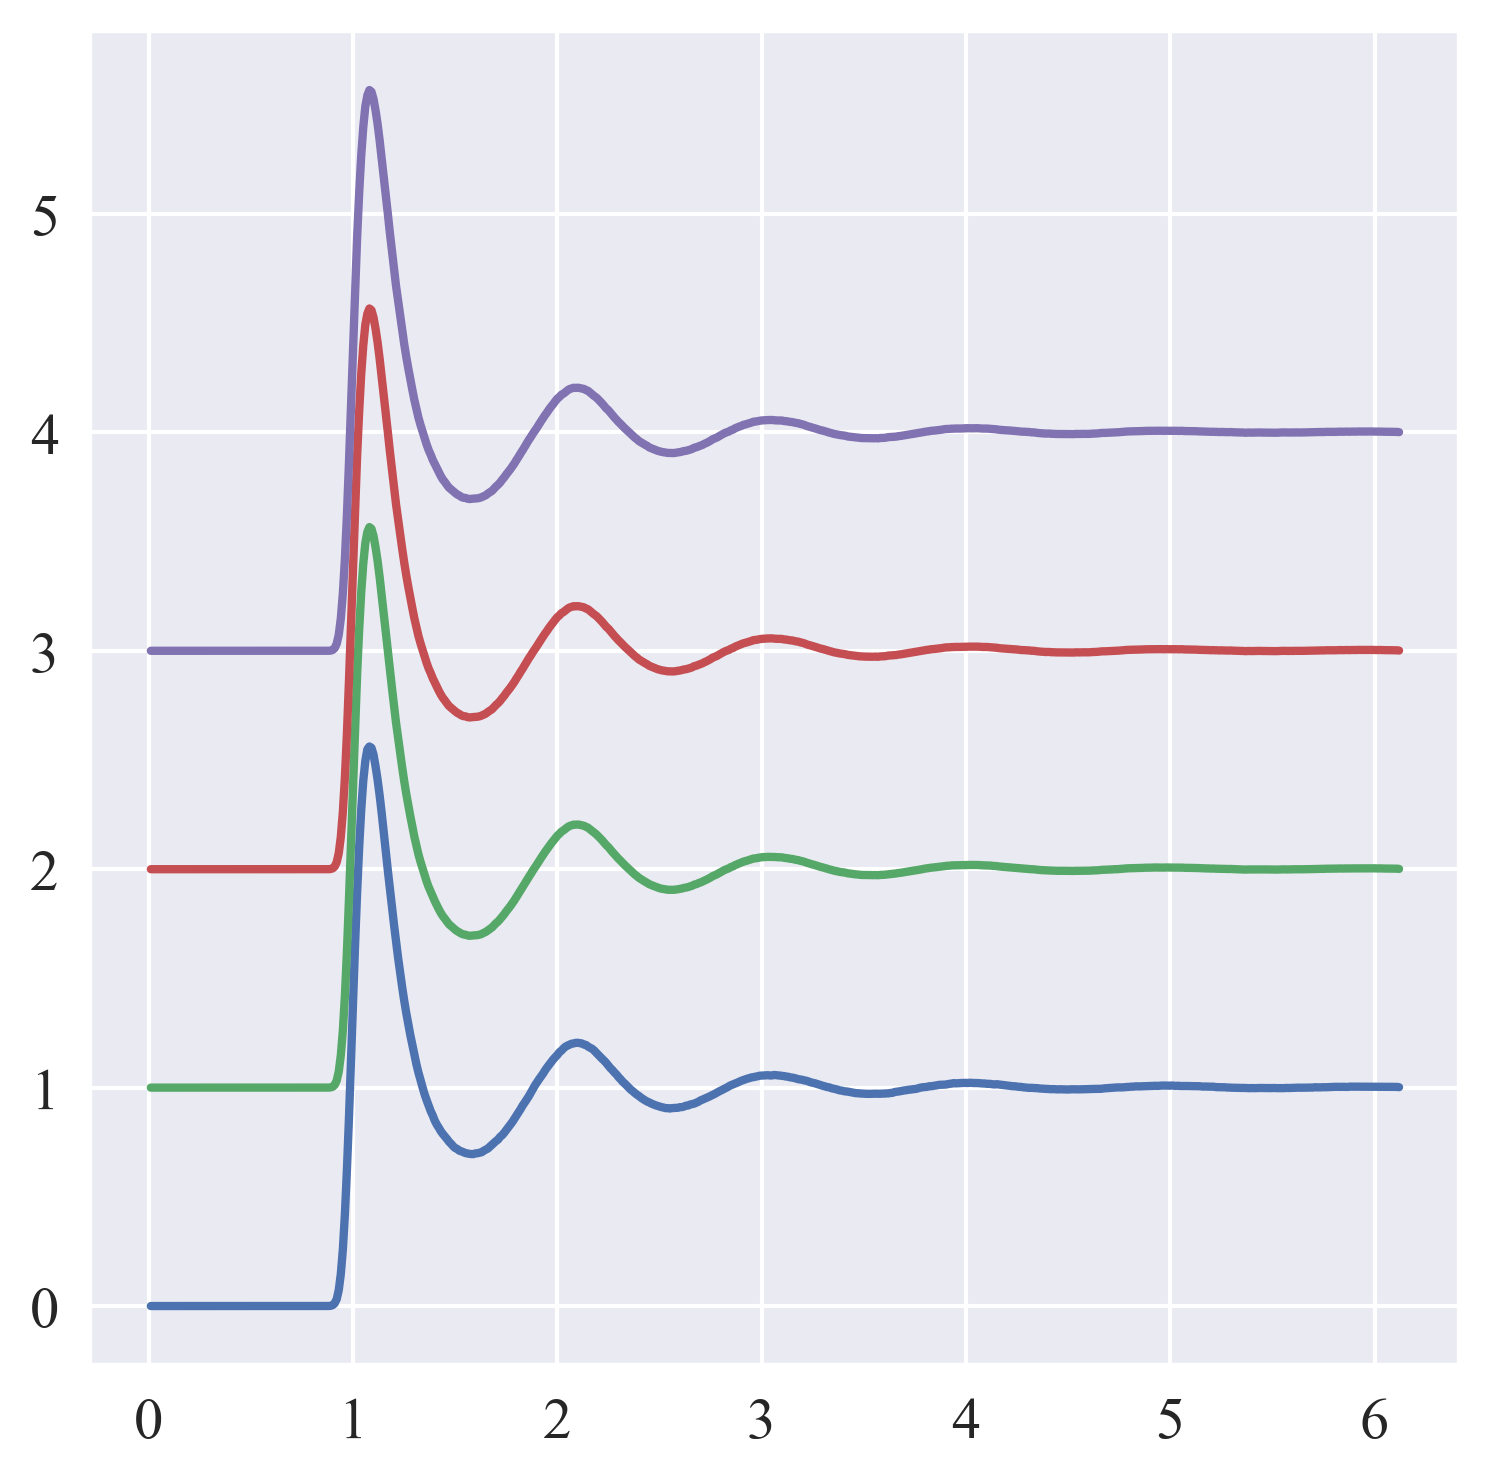

In [16]:
for i, hv in enumerate((0.1, 0.02, 0.004, 0.0008)):
    radiuses, rdf = [], []
    for r, regressor in regressors.items():
        radiuses.append(r)
        rdf.append(regressor.predict(np.array([[hv]]))[0])

    radiuses = np.array(radiuses)
    rdf = np.array(rdf)

    plt.plot(radiuses, rdf + i);